1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


In [ ]:
import numpy.random as npr
import numpy as np
from   scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

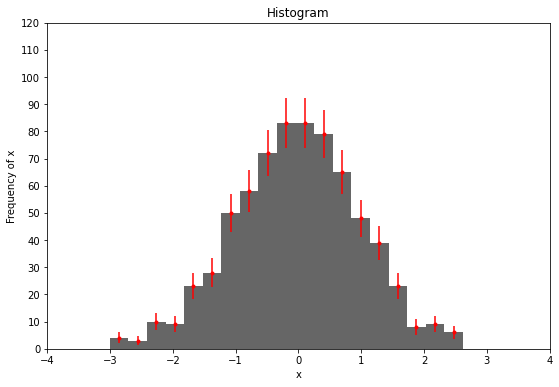

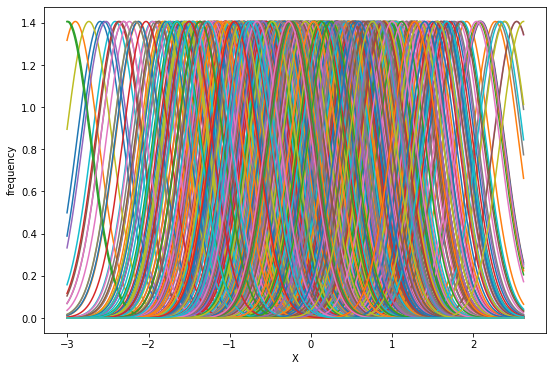

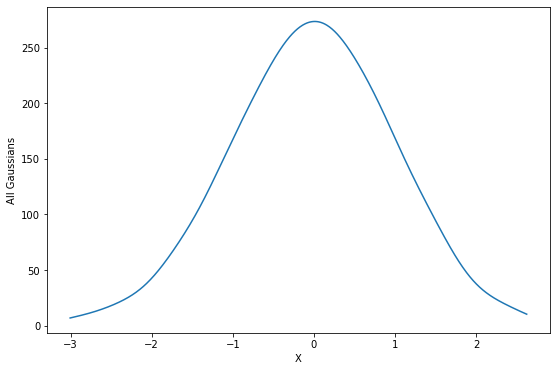

In [126]:
def std_func(x):
    
    return 1.06 * x.std() * (x.size ** (-1/5))

N= 700
mean= 0
sigma= 1

x = npr.normal(mean, sigma, N)

plt.figure(figsize=(9,6))

freq, edge, _=plt.hist(x, bins='auto', color='0', alpha=0.6)

bin_center = 0.5*(edge[1:]+edge[:-1])

plt.errorbar(bin_center, freq, yerr=np.sqrt(freq), fmt='.', color='r')

plt.xticks(np.arange(-4, 4.5, 1))

plt.yticks(np.arange(0,130,10))

plt.xlabel('x')

plt.ylabel('Frequency of x')

plt.title('Histogram')

plt.show()


plt.figure(figsize=(9,6))

X = np.linspace(min(x), max(x), N)

G=[]

plt.xlabel("X")

plt.ylabel("frequency")

for i in range(N):    
    
    gaussian = stats.norm.pdf(X, x[i], std_func(x))
    
    G.append(gaussian)
    
    plt.plot(X, gaussian)
    
plt.figure(figsize=(9,6))

All_Gaussian = np.sum(G, axis= 0)

plt.plot(X, All_Gaussian)

plt.xlabel('X')

plt.ylabel('All Gaussians')

plt.show()

2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

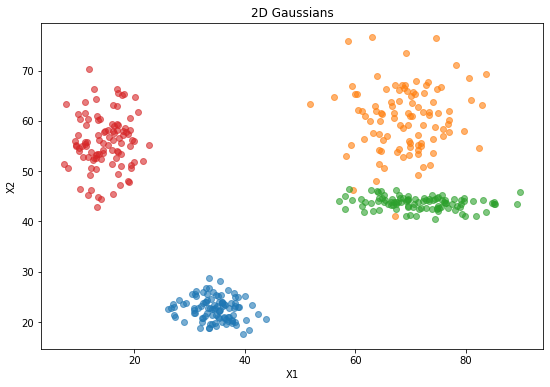

In [124]:
#just even numbers:
n=8          

X=[]

plt.figure(figsize=(9,6))

plt.xlabel("X1")

plt.ylabel("X2")

plt.title("2D Gaussians")

for i in range(n):
    
    X.append(npr.normal(npr.uniform(1,100), npr.uniform(1,10), 100))

for j in range(0, n , 2):

    plt.scatter(X[j], X[j + 1], alpha = 0.6)

3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should use the `np.load()` function to load the file as a numpy array, call the `.item()` method, and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

C:\Users\Enkidu\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


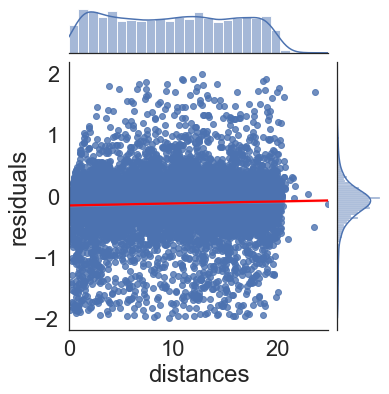

In [159]:
data = np.load("residuals_261.npy", allow_pickle=True)

data = data.item()

data = pd.DataFrame(data)

data = data[np.abs(data['residuals']) < 2]

#LinearRegresison:
result = stats.linregress(data['distances'], data['residuals'])

#SeaBorn:
plot = sns.jointplot(data['distances'], data['residuals'], data=data, kind='reg', joint_kws = {'line_kws':{'color':'red'}})